# Ch5. The Mechanics of Learning
---
딥러닝의 학습 방식은 다음과 같다.
1. 예측값과 실제값의 오차값 계산
2. 오차값에 따라 가중치를 변경. 이 때 변경 값은 미분 값을 연속으로 계산하는 규칙(Chain Rule)에 따라 정해진다.
3. 위 과정을 오차값이 일정 수준 이하가 될 때까지 반복

In [3]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

데이터는 아래 그림과 같은 분포를 띈다.
먼저 가장 간단한 모델인 선형 회귀로 예측해본다.
![image](https://user-images.githubusercontent.com/76675506/189033555-4ef958ce-6d77-49d7-a6d2-0b358a31a4a1.png)

모델의 예측값과 실제값의 오차를 줄이기 위해 우리는 **손실 함수**(**Loss Function**)을 사용한다.
손실 함수는 에러가 크면 똑같이 값이 커지도록 정의된다. 손실 함수 값이 가장 낮은 가중치(weight)와 편향치(bias)를 찾는다.
이 때, 손실 함수의 값은 절대값으로 표현함으로써 예측값이 실제값으로 맞춰갈 수 있도록 해야 한다.

온도를 예측하는 예제의 경우 $|X-\bar{X}|$와 $(X-\bar{X})^2$ 둘 중 하나를 손실 함수로 사용할 수 있다.
두 경우 모두 볼록(Convex)하기 때문에 다루기 좋다. 두 손실 함수 중에서 전자는 미분값이 0이 될 때 미분값을 정의할 수 없기 때문에 후자를 사용한다. *(실제로는 이러한 특징이 큰 문제가 되진 않는다.)*
또한 오차를 제곱한 경우가 더 바람직한 경우가 많은데, 오차에 대한 페널티를 더 많이 주기 때문이다.
![image](https://user-images.githubusercontent.com/76675506/189036782-6cc9b4d7-c1d5-4e54-a3e3-110466f9bc59.png)



In [22]:
def model(t_u, w, b):
    '''
    :param t_u: Input data
    :param w:  Weight
    :param b:  Bias
    :return: Regression result
    '''
    return w * t_u + b

def loss_fn(t_p, t_c):
    '''
    MSL(Mean Sqaure Loss): 오차의 제곱의 평균
    '''
    squared_diffs = (t_p - t_c) **2
    return squared_diffs.mean()

In [20]:
w = torch.ones(()) # 스칼라 값 생성 / 괄호를 하나만 하면 error 출력
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [24]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

### 브로드캐스팅(Broadcasting)
1. 러아ㅣㄴㅁ
2.

In [30]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f'shapes: x: {x.shape},     y: {y.shape}')
print(f'        z: {z.shape}, a: {a.shape}')
print("x * y:", (x * y).shape)
print('y * z:', (y * z).shape)
print('y * z * a:', (y * z * a).shape)

shapes: x: torch.Size([]),     y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


## 경사 하강(Gradient Descent)
---
각 파라미터와 관련해 손실의 변화율을 계산해 손실이 줄어드는 방향으
로 파라미터 값을 바꿔나간다.

아래 코드는 손실값의 변화율에 따라 `w`의 변화율을 조정하는 코드다.
즉, 손실값이 줄어들면 `w`를 늘려서 손실을 최소화 하고, 손실값이 늘어나면 `w`를 줄여서 손실을 최소화하는 방식이다.
b에 대해서도 동일하게 적용한다.

In [34]:
delta = 0.1

loss_rate_of_change_w = (
    loss_fn(model(t_u, w + delta, b), t_c)-
    loss_fn(model(t_u, w + delta, b), t_c) / (2.0 * delta))

In [35]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [36]:
loss_rate_of_change_b = (
    loss_fn(model(t_u, w, b + delta), t_c) -
    loss_fn(model(t_u, w, b + delta), t_c) / (2.0 * delta))

In [37]:
b = b - learning_rate * loss_rate_of_change_b

위와 같은 작업을 반복함으로써 손실값을 최소화하는 최적의 파라미터 값으로 수렴하게 된다. 다만 지금은 변화율이 너무 심해서 조정할 필요가 있다. 그 이유와 어떻게 조정하는지 알아보자.

### 미분 계산하기
---
파라미터에 대한 손실 함수의 미분을 계산하려면 연쇄 규칙을 적용한다.

```d loss_fn / d w = (d loss_fn / d t_p) * (d t_p / d w)```

기존 `loss_fn`과 비교하여 아래 `dloss_fn`을 살펴보자

In [38]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # 평균의 도함수로 나눔
    return dsq_diffs

### 미분 적용하기
---
우리의 모델은 ```w * t_u + b```의 형태임을 상기하면서 아래 미분 함수를 살펴보자.

In [42]:
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

### 경사 함수 정의하기
---
w와 b에 대한 손실 함수 값의 미분을 반환하는 함수는 아래와 같다.

![image](https://user-images.githubusercontent.com/76675506/189056228-7a54985b-a5f0-4f26-ac26-ef2639a34ef6.png)


In [43]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()]) # sum은 파라미터를 모델의 전체 입력 벡터에 대해 적용하던 브로드캐스팅의 역순이다.

In [47]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs, +1):
        w, b = params

        t_p = model(t_u, w, b) # 순방향 전파
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # 역전파

        params = params - learning_rate * grad # 업데이트

        print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [52]:

def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

In [53]:
training_loop(
    n_epochs= 100,
    learning_rate= 1e-2,
    params= torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

파라미터 조정이 너무 크기 때문에 값이 발산해 버렸다. 어떻게 해야 `learning_rate * grad` 크기를 적절하게 잡을 수 있을까?
`learning_rate`의 값을 더 작게 조정하면 된다. 1e-2 대신 1e-4를 넣어보자.

In [54]:
training_loop(
    n_epochs = 100,
    learning_rate=1e-4,
    params=torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

안정적으로 동작하지만 조정폭이 너무 좁아 나중엔 손실이 줄어들지 않고 멈춰버린다. 이 문제는 `learning_rate`을 조정 규모에 따라 변하게 만들어 방지할 수 있다. *(뒤에서 살펴본다.)*

그 전에 잠재적으로 문제가 될 수 있는 기울기를 살펴보자.
위 결과에서 epoch 1을 보면 w(4517)와 b(82)의 값의 차이가 큰 것을 알 수 있다. **정규화**를 통해 이를 해결할 수 있다.

In [55]:
t_un = 0.1 * t_u

In [56]:
training_loop(
    n_epochs=100,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c
)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

정규화를 거치고 나면 기울기를 1e-2로 설정해도 발산하지 않는다.

In [59]:
params = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c,
    print_params=False
)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


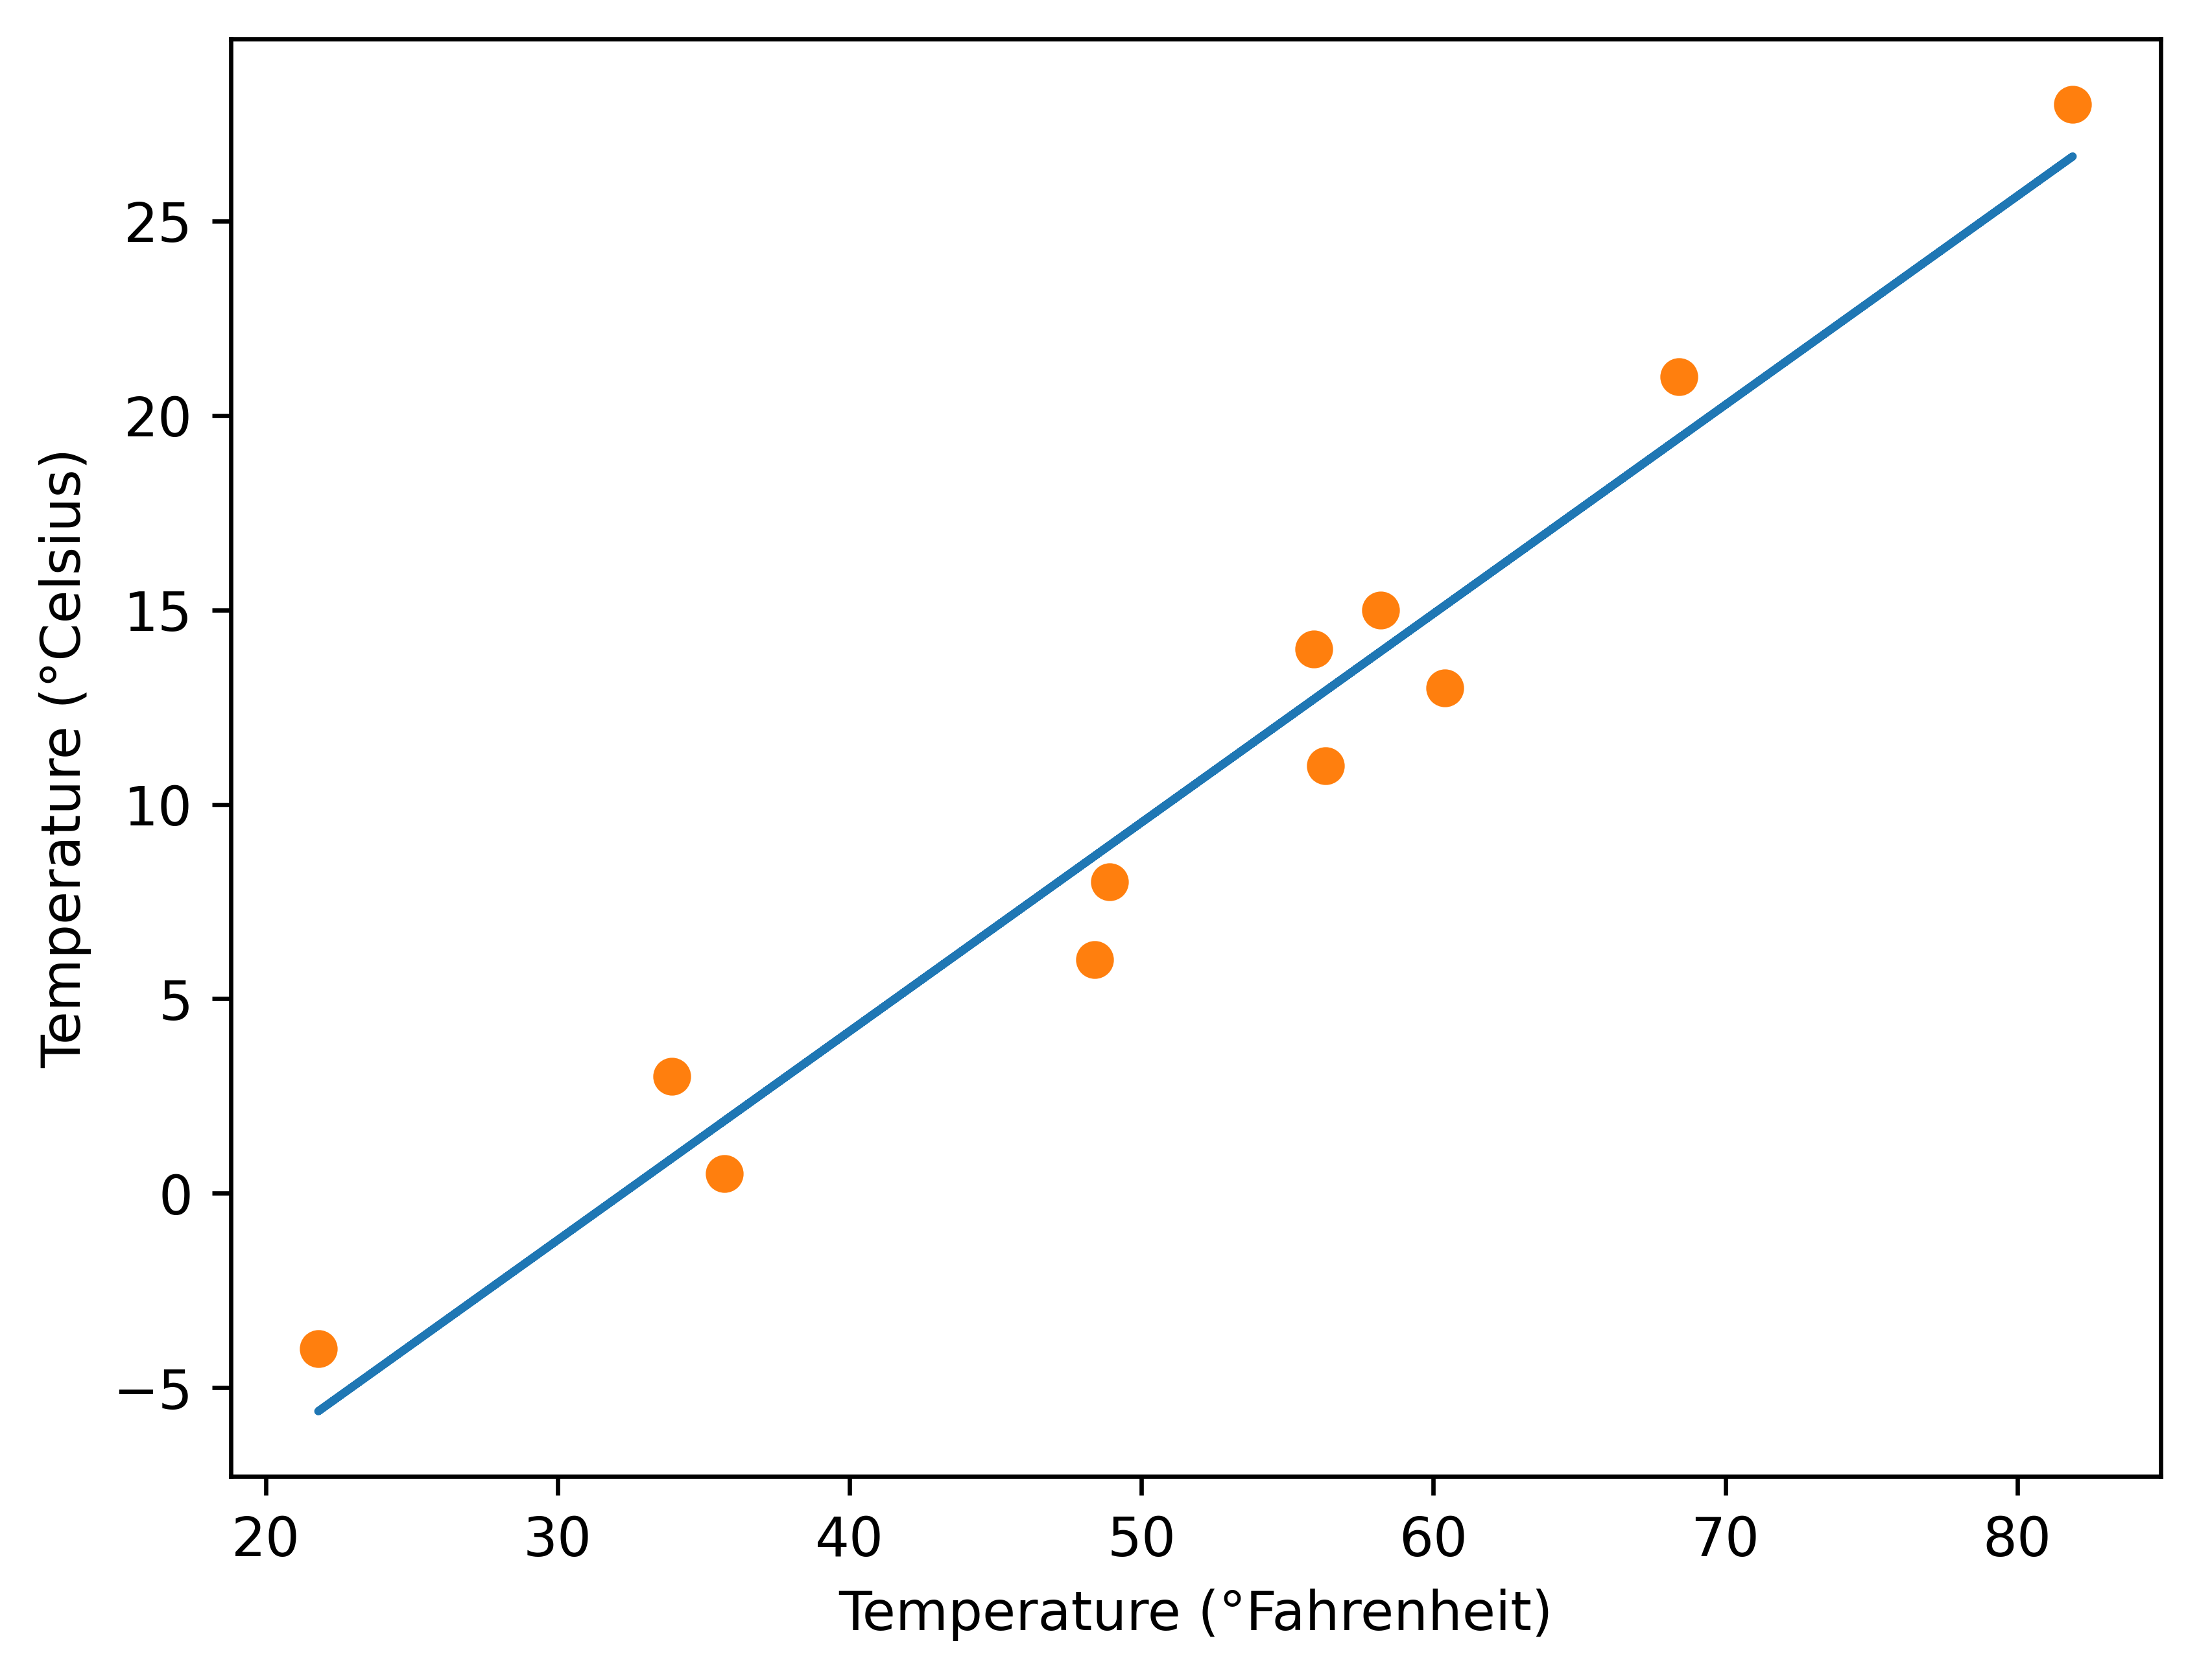

In [60]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params) # 인자 언패킹(Argument Unpacking)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

### 인자 언패킹(Argument Unpacking)
34124

## 파이토치의 자동미분
---
`requires_grad`
- 텐서를 조작해서 나온 다른 텐서 전부 기억하도록 만드는 인자
- 아래의 경우 `params`로부터 만들어진 모든 텐서는 만들어지는 과정의 모든 함수에 접근할 수 있다.
- 위 함수들이 미분 가능한 경우 텐서의 `grad` 속성으로 기록된다.

In [64]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [65]:
params.grad is None

True

In [69]:
def loss_fn(t_p, t_c):
    squred_diffs = (t_p - t_c)**2
    return squred_diffs.mean()

In [70]:
loss =  loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

loss를 계산할 때 파이토치는 아래 그림과 같은 미분 그래프를 만들어둔다. 그 후 `loss.backward()`를 호출할 때, 그래프를 거꾸로 따라가면서 기울기를 계산한다.
<img src="https://user-images.githubusercontent.com/76675506/189076093-01612915-05e9-4862-9562-6abeec0f7722.png" width="500" height = "500">
<span style="color:blue">some *blue* text</span>.

> backward는 미분을 리프 노드에 누적시킨다. 따라서 파라미터 조정을 위해 사용한 후에는 기울기를 다시 0으로 초기화 시켜야 한다.


In [71]:
if params.grad is not None:
    params.grad.zero_()

In [72]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

`with`
https://peps.python.org/pep-0343/
`torch.no_grad()`
- grdient

파이토치는 `backward`가 사용되면 순방향 그래프를 소모(consume)하면서 리프 노드인 params를 얻게 된다. 하지만 우리는 새로운 순방향 그래프를 만들기 전에 리프 노드를 바꾸길 원한다. 이 부분은 옵티마이저 안에서 구현한다. `no_grad` 역시 추후 구체적으로 알아본다.

In [73]:
training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

### 옵티마이저
---
일반적으로 옵티마이저는 파라미터 리스트를 받을 때 `requires_grad`가 `True`로 설정된 파이토치 텐서를 받는다.
모든 옵티마이저는 `zero_grad`와 `step`이라는 두 가지 메소드를 제공한다.
![image](https://user-images.githubusercontent.com/76675506/189086160-82acc316-6264-4c99-80a4-263369535c4f.png)

In [74]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [75]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

SGD(Stochastic Gradient Descent)
: 미니 배치(mini batch)라고 불리는 여러 샘플 중에서 임의로 뽑아(Stochastic) 평균을 계산한다.

In [76]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [77]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [78]:

def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

두 <1> 부분의 params가 동일하지 않으면 옵티마이저는 모델이 사용하는 파라미터가 어떤 것인지 알 수 없다.

In [79]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params, # <1>
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

Adam 옵티마이저
- 학습률이 동적으로 변한다.
- 파라미터 비율 조정에도 강건하기 때문에 정규화를 진행하지 않은 `t_u`를 사용하고 학습률 또한 1e-1로 올려도 지장이 없다.

In [80]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2>
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

## 훈련, 검증, 과적합
---
데이터의 일부를 떼어놓고 Validation set과 Training set으로 구분해서 모델을 검증할 수 있다.

과적합을 방지하기 위해선 **페널티항**(**Penalization term**)을 만들어 모델의 피팅을 더 천천히, 부드럽게 만들 수 있다. 또는 입력 데이터에 **노이즈**를 더할 수 있다.

먼저 모델의 단순화를 진행해보자. `randperm` 함수는 텐서 요소를 섞었을 때의 인덱스 리스트를 반환한다.

In [83]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indeices = shuffled_indices[-n_val:]

train_indices, val_indeices

(tensor([0, 4, 7, 5, 3, 6, 8, 2, 1]), tensor([ 9, 10]))

In [91]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indeices]
val_t_c = t_c[val_indeices]

train_t_un = 0.01 * train_t_u
val_t_un = 0.01 * val_t_u

에포크마다 검증셋에 대한 loss를 계산해서 과적합하고 있는지 파악한다.

In [85]:

def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [93]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1>
    val_t_u = val_t_un, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)

TypeError: model() missing 1 required positional argument: 'b'

### 자동 미분의 주의사항
---
`training_loop`에서 `val_loss`에 대해 `backward`를 호출하게 된다면 `param` 텐서에는 `train`에 대한 미분값과 `valid`에 대한 미분값이 두 번 누적되게 된다. 이러한 일이 발생하지 않도록 주의해야 한다.

### 자동 미분 끄기
---
`val_loss`에 대해 `backward`를 호출하지 않는다면 연산 그래프(`required_grad`)를 만들 필요가 있을까?
연산 그래프 생성에는 속도나 메모리 등의 비용이 들어간다. 이는 모델이 커질수록 더 커지기 마련이다.

이를 위해 `torch.no_grad`를 사용해 자동미분을 끌 수 있다. `with`문과 함께 사용해야 한다.

In [ ]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # 컨텍스트 관리자
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [ ]:
def calc_forward(t_u, t_c, is_train:bool):
    '''
    자동 미분을 켤지 끌지 제어
    :param is_train: 자동 미분 여부
    :return:
    '''
    with torch.set_grad_enabled(is_train):
        t_p=model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

## 연습 문제
---
1. 이 모델을 `w2 * t_u **2 + w1 * t_u + b`로 다시 정의하자.
    1. 이 모델을 다루기 위해 훈련 루프의 어떤 부분을 변경해야 하나?
       - *정규화를 더 강하게 해야한다.*
    2. 모델 변경과 무관한 부분은 어디인가?
       -  *`training_loop`부분*
    3. 실제 결과가 좋아졌나 나빠졌나?
       - *아주 약간 더 나아졌다.*

In [87]:
def model(t_u, w2, w1, b):
    '''
    :param t_u: Input data
    :param w2:  Weight
    :param w1:  Weight
    :param b:  Bias
    :return: Regression result
    '''
    return w2 * t_u **2 + w1 * t_u + b

In [88]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [92]:
params = torch.tensor([1.0, 1.0, 0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
0.01
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1>
    val_t_u = val_t_un, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 142.3607, Validation loss 269.3491
Epoch 2, Training loss 137.9431, Validation loss 260.8592
Epoch 3, Training loss 133.7513, Validation loss 252.7261
Epoch 500, Training loss 26.3183, Validation loss 24.0599
Epoch 1000, Training loss 12.2315, Validation loss 12.4791
Epoch 1500, Training loss 6.3091, Validation loss 7.2833
Epoch 2000, Training loss 3.8191, Validation loss 4.8870
Epoch 2500, Training loss 2.7722, Validation loss 3.7423
Epoch 3000, Training loss 2.3320, Validation loss 3.1721


tensor([26.2147, 23.0145, -9.1626], requires_grad=True)